In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

'''

*** Libraries/Modules and their Uses***
(Model imports need no explanation)

pandas for dealing with the csv file

re(regular expressions) to manipulate text, used to remove html tags and any special characters
apart from capital, small letters and space

stopwords to remove words that are not that useful for our model's learning

word_tokenize breaks down the text into individual tokens

PorterStemmer to reduce words to thier root forms

WordNetLemmatizer further reduces to their dictionary form

CountVectorizer builds a vocabulary and then returns count matrix

wordcloud and plt to plot

'''

"\n\n*** Libraries/Modules and their Uses***\n(Model imports need no explanation)\n\npandas for dealing with the csv file\n\nre(regular expressions) to manipulate text, used to remove html tags and any special characters\napart from capital, small letters and space\n\nstopwords to remove words that are not that useful for our model's learning\n\nword_tokenize breaks down the text into individual tokens\n\nPorterStemmer to reduce words to thier root forms\n\nWordNetLemmatizer further reduces to their dictionary form\n\nCountVectorizer builds a vocabulary and then returns count matrix\n\nwordcloud and plt to plot\n\n"

In [2]:

df=pd.read_csv("Reviews_dataset.csv")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
'''Designing a function that takes in text and preprocesses it, removing html tags,
special characters and reducing words to their root form'''

def preprocess_text(text):
    if pd.isna(text): 
        return ""

    text = text.lower()  
    text = re.sub(r'<.*?>', ' ', text) 
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = word_tokenize(text)  
    tokens = [word for word in tokens if word not in stop_words]  
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)


In [4]:
df['cleaned_review'] = df['review'].astype(str).apply(preprocess_text)
df['cleaned_review'].head()

0    one reviewer mentioned watching oz episode you...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: cleaned_review, dtype: object

In [5]:
sia = SentimentIntensityAnalyzer()

In [6]:
'''Applying the model'''

df['sentiment_scores'] = df['cleaned_review'].apply(sia.polarity_scores)
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
df['sentiment'] = df['compound_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
print(df[['cleaned_review', 'compound_score', 'sentiment']].head())

                                      cleaned_review  compound_score sentiment
0  one reviewer mentioned watching oz episode you...         -0.9929  negative
1  wonderful little production filming technique ...          0.9606  positive
2  thought wonderful way spend time hot summer we...          0.9688  positive
3  basically there family little boy jake think t...         -0.9061  negative
4  petter matteis love time money visually stunni...          0.9887  positive


In [7]:
df.to_csv("Predictions.csv")

In [ ]:
'''Topic modelling using LDA'''

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_review'])
topics=5
lda_model = LatentDirichletAllocation(n_components=topics, random_state=42)
lda_model.fit(X)


def display_topics(model, feature_names, num_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_words
    return topics

topics = display_topics(lda_model, vectorizer.get_feature_names_out(), num_words=10)
topics


{'Topic 1': ['film',
  'time',
  'character',
  'like',
  'good',
  'comedy',
  'movie',
  'scene',
  'make',
  'story'],
 'Topic 2': ['film',
  'movie',
  'story',
  'life',
  'character',
  'people',
  'time',
  'love',
  'like',
  'make'],
 'Topic 3': ['film',
  'performance',
  'role',
  'great',
  'play',
  'best',
  'good',
  'scene',
  'character',
  'movie'],
 'Topic 4': ['movie',
  'like',
  'film',
  'good',
  'bad',
  'really',
  'dont',
  'time',
  'make',
  'watch'],
 'Topic 5': ['like',
  'time',
  'episode',
  'man',
  'series',
  'thing',
  'little',
  'kid',
  'good',
  'movie']}

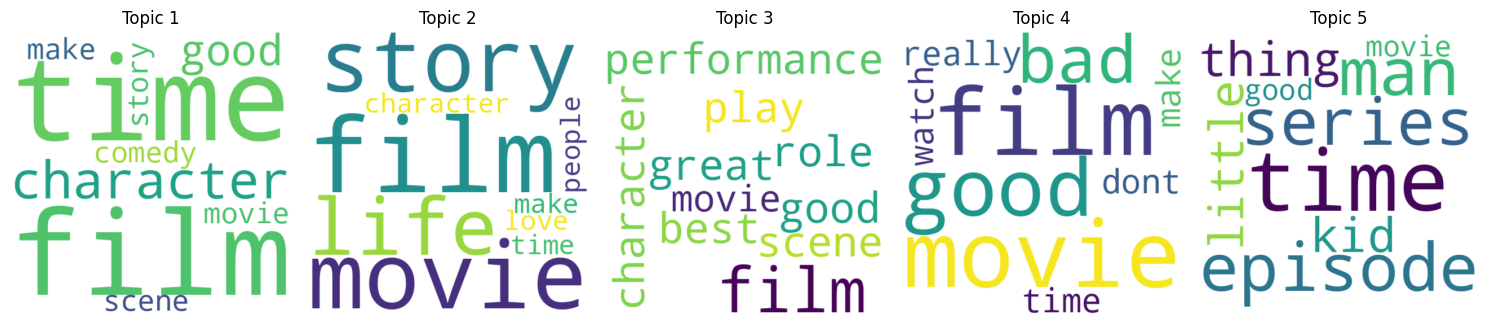

In [9]:
'''WordbyWord , LDA prooven to not be that efficient, so later applied Bigram LDA after 
removing custom stopwords'''

num_topics = len(topics)
    
fig, axes = plt.subplots(1, 5, figsize=(15, 8))

for idx, (topic, words) in enumerate(topics.items()):
    wordcloud = WordCloud(width=500, height=500, background_color="white").generate(" ".join(words))
    
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(topic, fontsize=12)
    axes[idx].axis("off")  

plt.tight_layout()
plt.show()

In [10]:
'''Finding most occurring words and removing them'''
word_counts = X.toarray().sum(axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
common_words = [word for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]]
print("Most common words to remove:", common_words)


Most common words to remove: ['movie', 'film', 'like', 'time', 'good', 'character', 'story', 'make', 'really', 'scene', 'people', 'great', 'bad', 'dont', 'way', 'thing', 'think', 'life', 'know', 'watch']


In [11]:

df["filtered_reviews"] = df["cleaned_review"].apply(lambda text: [word for word in text.split() if word not in common_words])
df["filtered_reviews"]

0        [one, reviewer, mentioned, watching, oz, episo...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, spend, hot, summer, weeke...
3        [basically, there, family, little, boy, jake, ...
4        [petter, matteis, love, money, visually, stunn...
                               ...                        
49995    [thought, right, job, wasnt, creative, origina...
49996    [plot, dialogue, acting, idiotic, directing, a...
49997    [catholic, taught, parochial, elementary, scho...
49998    [im, going, disagree, previous, comment, side,...
49999    [one, expects, star, trek, high, art, fan, exp...
Name: filtered_reviews, Length: 50000, dtype: object

In [ ]:
'''Applying Bigram LDA'''
df['cleaned_text'] = df['filtered_reviews'].apply(lambda x: " ".join(x))

vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000, stop_words='english') 
X = vectorizer.fit_transform(df['cleaned_text'])

lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, random_state=42)
lda_topics = lda_model.fit_transform(X)

words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:]]  
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

Topic 1: havent seen, horror flick, horror fan, romantic comedy, low budget, im sure, worst seen, worst ive, high school, ive seen
Topic 2: small town, best friend, low budget, academy award, supporting cast, soap opera, comic book, young man, year later, year ago
Topic 3: year ago, serial killer, havent seen, old man, young woman, star trek, black white, tv series, world war, new york
Topic 4: high school, worth seeing, definitely worth, kung fu, hong kong, worth watching, martial art, new york, fall love, year old
Topic 5: youre looking, half hour, video game, gon na, waste money, star war, im sure, low budget, read book, special effect


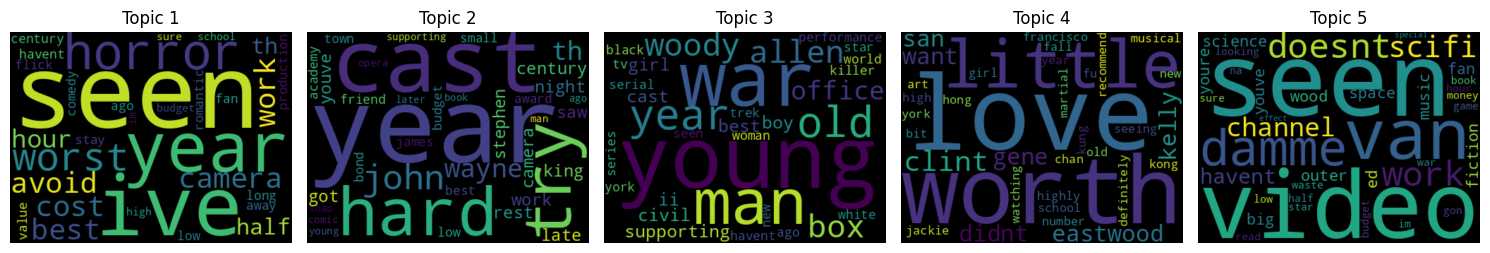

In [13]:
'''Plotting'''
fig, axes = plt.subplots(1, 5, figsize=(15, 8))

for i, topic in enumerate(lda_model.components_):
    wordcloud = WordCloud(width=400, height=300).generate(" ".join([words[j] for j in topic.argsort()[-20:]]))
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
'''Had different files for Visualisations, so had to integrate in one, 
the post model and pre model visualisations are as follows'''

from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline


In [15]:
df=pd.read_csv("Predictions.csv")
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['cleaned_review_length']=df['cleaned_review'].apply(lambda x: len(x.split()))

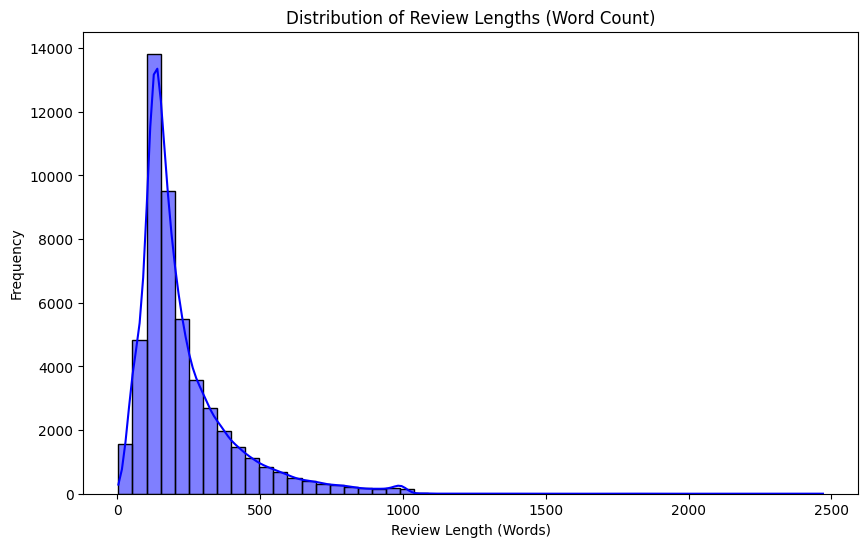

In [16]:
# Plot distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths (Word Count)')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()

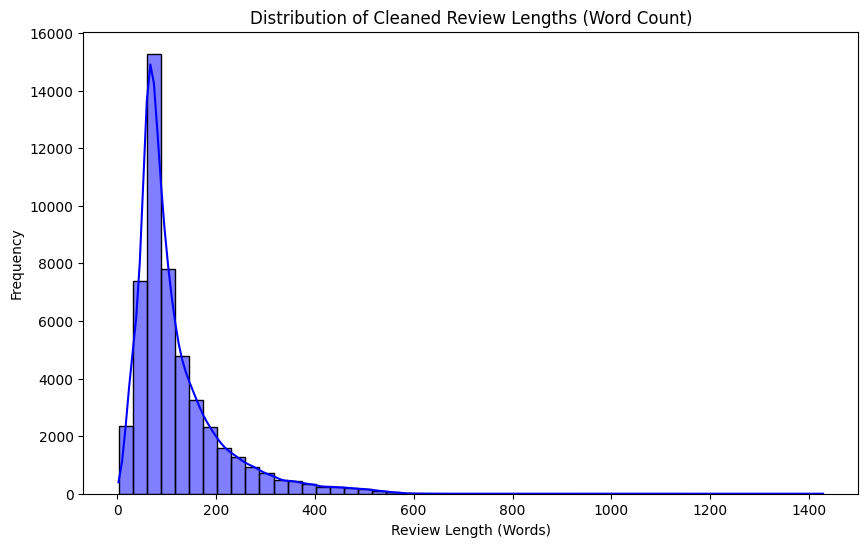

In [17]:
# Plot distribution of cleaned review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['cleaned_review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Cleaned Review Lengths (Word Count)')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()

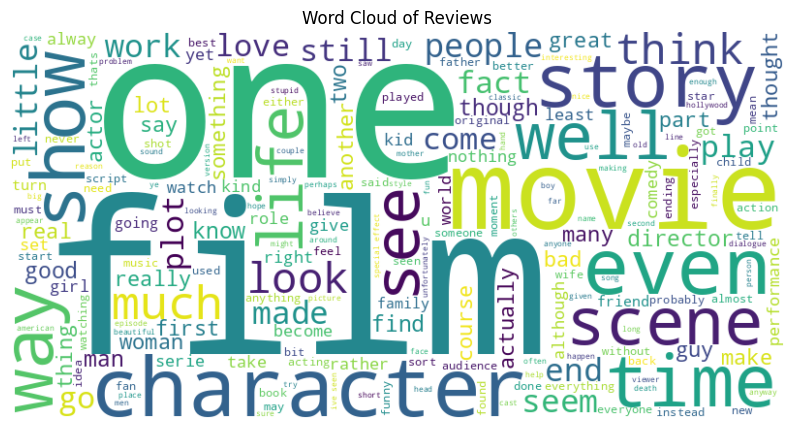

In [18]:
# Word Cloud of all reviews
all_reviews = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

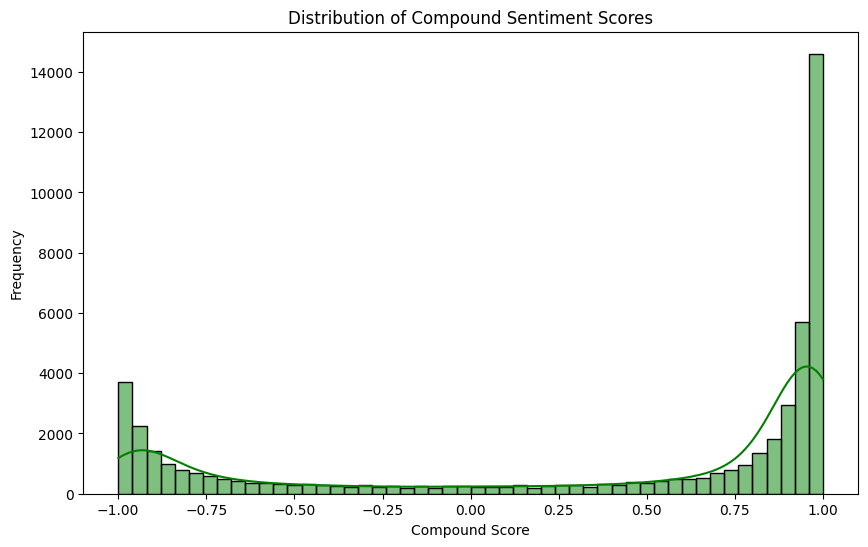

In [19]:
# Plot distribution of compound sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['compound_score'], bins=50, kde=True, color='green')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\anura\AppData\Local\Temp\ipykernel_13088\1240783282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


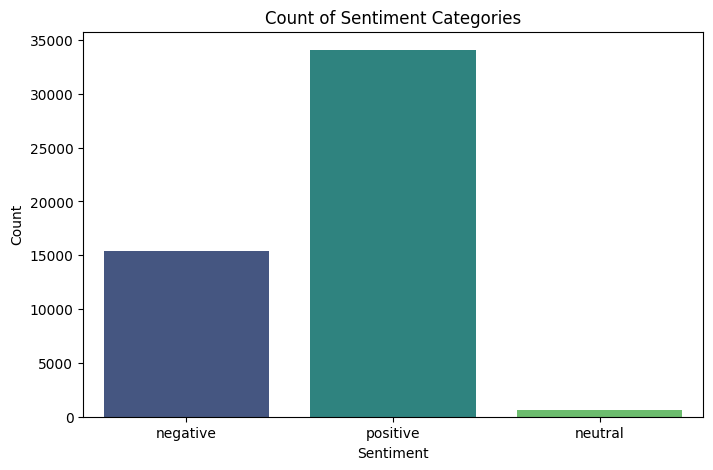

In [20]:
# Count plot of sentiment categories
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Count of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

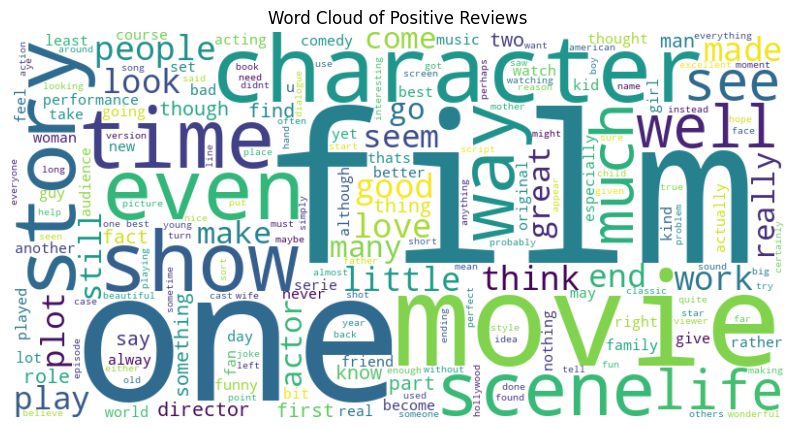

In [21]:

# Word Cloud for Positive Reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()


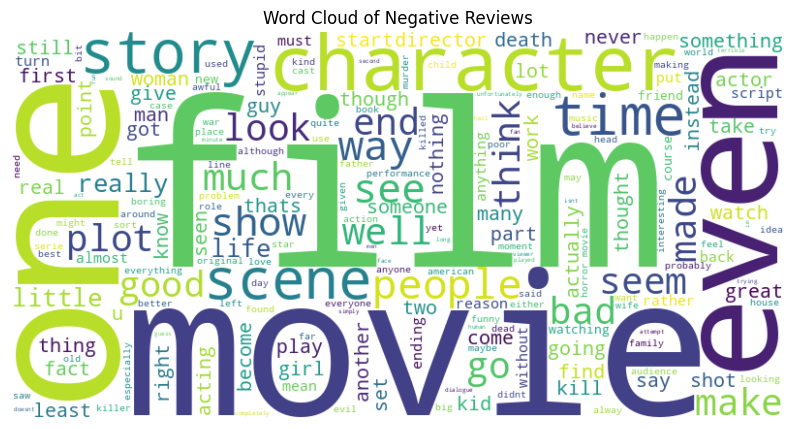

In [22]:
# Word Cloud for Negative Reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()